In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2 as cv

import numpy as np
from scipy import special
from scipy.stats import kstwobign, anderson

In [10]:
combine_fold = 'C:/Users/oryan/Documents/mergers-in-cosmos/cats-to-combine'
data_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-data'
fig_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures'

In [11]:
df_cat = pd.read_csv(f'{combine_fold}/cosmos2020-categorised-interactions.csv', index_col = 0)

In [12]:
df_cat

,ORyan23_ID,ID,category,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,4000705532455,816891,stage3,150.679846,2.196543,9200.399414,21737.232422,0.000052,0.000059,-1.043282e-05,...,-8.931825,-8.911355,-8.899668,-8.883307,-8.872990,0.529107,0.560142,0.599624,0.630920,0.652330
1,4000705533383,861738,stage1,150.645118,2.237538,10033.689453,22720.843750,0.000039,0.000078,1.332813e-05,...,-9.574272,-9.548649,-9.503962,-9.439343,-9.384205,0.240042,0.281559,0.330791,0.384371,0.436491
2,4000705539529,1284864,stage1,149.686223,2.637412,33027.406250,32317.517578,0.000031,0.000030,1.244353e-06,...,-9.669377,-9.614943,-9.570104,-9.533121,-9.476167,0.094187,0.114436,0.140990,0.159430,0.183608
3,4000705539941,1301188,stage2,149.702462,2.654895,32637.949219,32737.013672,0.000064,0.000104,-2.881107e-06,...,-9.794128,-9.784252,-9.766013,-9.743796,-9.727879,0.018737,0.018737,0.018737,0.018737,0.018737
4,4000705540034,1304538,stage1,149.726828,2.658172,32053.712891,32815.468750,0.000071,0.000086,-6.036952e-06,...,-9.480532,-9.443615,-9.402433,-9.352081,-9.325659,0.302629,0.376027,0.440394,0.508153,0.567727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791,6000535066150,1157587,stage4,150.422510,2.514655,15373.875977,29370.304688,0.000024,0.000027,8.697323e-06,...,-13.220035,-13.215519,-10.469687,-9.954029,-9.691111,0.173505,0.240862,0.328586,0.439079,0.546386
3792,6000535121452,1035987,stage1,149.694761,2.397231,32824.328125,26552.759766,0.000012,0.000015,-7.174042e-07,...,-10.287872,-10.060802,-9.853634,-9.456022,-9.315375,0.343488,0.463897,0.646257,1.016819,1.285051
3793,6000535865556,1138628,stage1,150.490889,2.496660,13734.171875,28938.828125,0.001929,0.001333,1.953999e-04,...,-9.875473,-9.817194,-9.580817,-9.265499,-9.099182,0.026873,0.026873,0.164250,0.549086,0.751945
3794,6000536013605,1203157,stage1,150.202813,2.558504,20641.730469,30421.910156,0.000051,0.000067,4.840965e-07,...,-9.804204,-9.683063,-9.470870,-9.189605,-8.982660,0.539500,0.595082,0.778112,1.062422,1.232495


In [13]:
df_red_tmp = df_cat.query('ez_sfr < 10')
df_red = df_red_tmp.query('lp_mass_best > 6.5')

In [14]:
def create_plot_ez(df, ax, stage, control):
    
#     ax_histx = fig.add_subplot(gs[0,0],sharex=ax)
#     ax_histy = fig.add_subplot(gs[1,1],sharey=ax)
    
#     scatter_hist(np.array(list(df.mass_best_1)), np.array(list(df.sfr_best_1)), ax, ax_histx, ax_histy, 'black')
    
    df.plot.scatter(
        x = 'lp_mass_best',
        y = 'ez_sfr',
        ax = ax,
        xlim = [5.5,12.5],
        ylim = [-6,3.0],
        xlabel = '',
        ylabel = '',
        title = f'{control} {stage}',
        color = 'black',
        alpha = 0.25,
        s = 5
    )

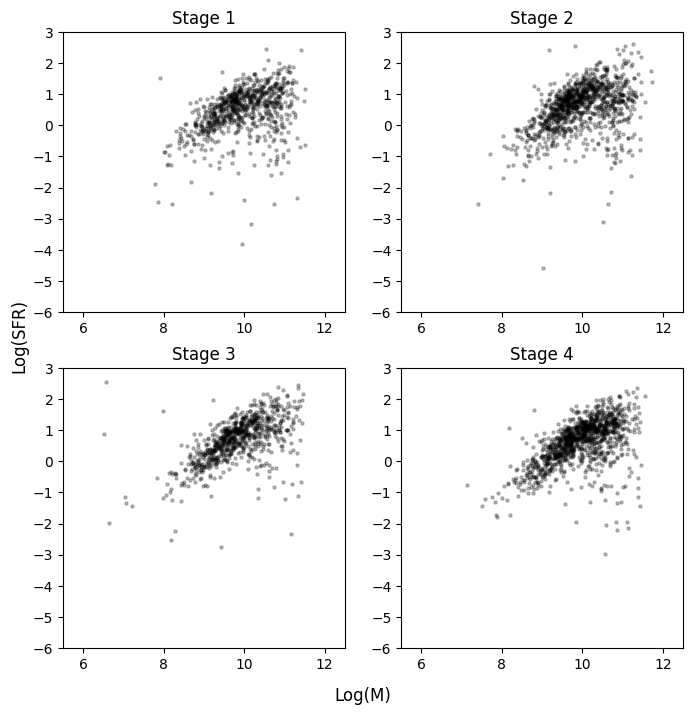

In [15]:
counter = 1
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
for i in range(2):
    for j in range(2):
        create_plot_ez(df_red.query(f'category == "stage{counter}"'), axes[i,j], counter, 'Stage')
        counter += 1
        
fig.text(0.5, 0.05, 'Log(M)', ha='center', va='center', fontsize = 12)
fig.text(0.07, 0.5, 'Log(SFR)', ha='center', va='center', rotation='vertical', fontsize = 12)

plt.show()

In [16]:
def scatter_hist(x, y, ax, ax_histx, ax_histy, colour):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, s = 0.5, color=colour, alpha = 0.25)
    #threshold = 0.065
    sns.kdeplot(x=x,y=y, ax=ax, thresh = 0.1, levels=8, color='orange')
    ax.set_xlim([6.5,12.5])
    ax.set_ylim([-5, 3.5])

    # now determine nice limits by hand:
    binwidth = 0.15
    xymax = max(12.5, 3.5)
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins, histtype = 'step', color = colour)
    ax_histy.hist(y, bins=bins, orientation='horizontal', histtype='step', color=colour)

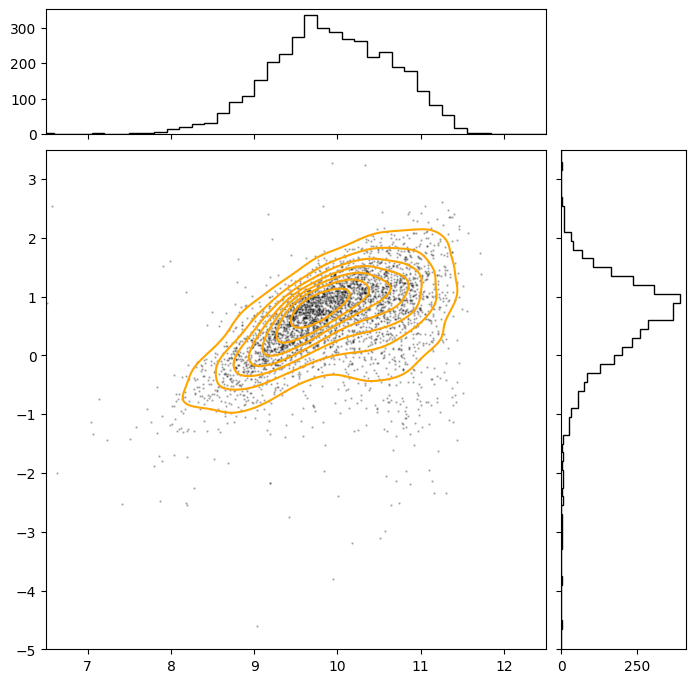

In [17]:
fig = plt.figure(figsize = (8,8))
gs = fig.add_gridspec(2,2, width_ratios = (4,1), height_ratios = (1,4), left = 0.1, right = 0.9, bottom = 0.1, top = 0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])
ax_histx = fig.add_subplot(gs[0,0],sharex=ax)
ax_histy = fig.add_subplot(gs[1,1],sharey=ax)

# colours = ['black','blue','red','orange']

scatter_hist(np.array(list(df_red.lp_mass_best)), np.array(list(df_red.ez_sfr)), ax, ax_histx, ax_histy, 'black')

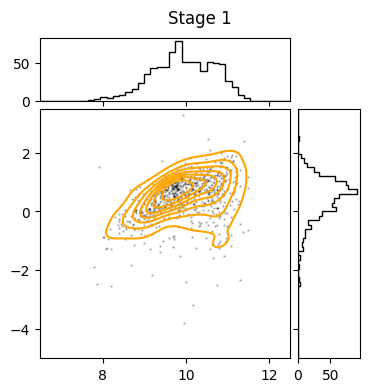

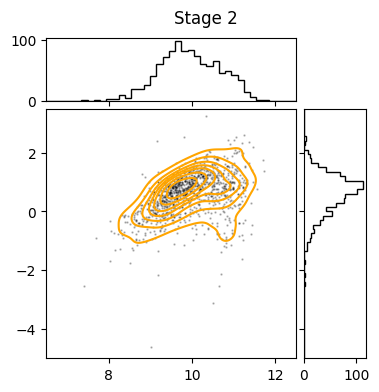

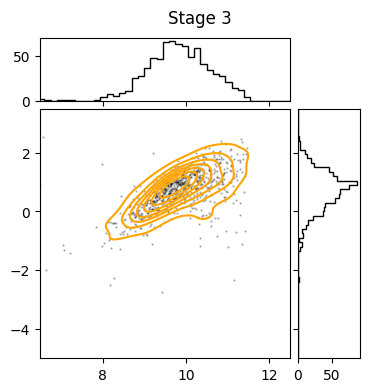

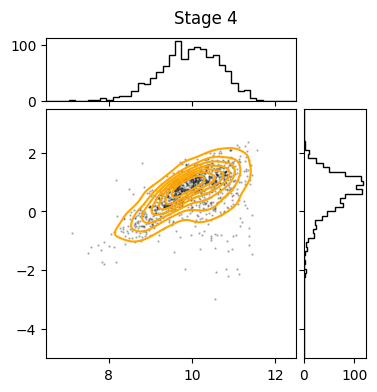

In [18]:
# colours = ['black','blue','red','orange']

for i in range(0,4):
    
    fig = plt.figure(figsize = (4,4))
    gs = fig.add_gridspec(2,2, width_ratios = (4,1), height_ratios = (1,4), left = 0.1, right = 0.9, bottom = 0.1, top = 0.9, wspace=0.05, hspace=0.05)

    ax = fig.add_subplot(gs[1,0])
    ax_histx = fig.add_subplot(gs[0,0],sharex=ax)
    ax_histy = fig.add_subplot(gs[1,1],sharey=ax)
    
    df_stage = df_red.query(f'category == "stage{i+1}"')

    scatter_hist(np.array(list(df_stage.lp_mass_best)), np.array(list(df_stage.ez_sfr)), ax, ax_histx, ax_histy, 'black')
    
    fig.text(0.5, 0.95, f'Stage {i + 1}', ha='center', va='center', fontsize = 12)
    
    plt.savefig(f'{fig_folder}/stage{i+1}.jpeg', bbox_inches = 'tight', dpi = 100)
    
    plt.show()

### Testing with Image Trick

In [19]:
fig_folder

'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures'

In [20]:
im_files = glob.glob(f'{fig_folder}/sfr-stages/*.jpeg')

In [21]:
im_files

['C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures/sfr-stages\\stage1.jpeg',
 'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures/sfr-stages\\stage2.jpeg',
 'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures/sfr-stages\\stage3.jpeg',
 'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures/sfr-stages\\stage4.jpeg']

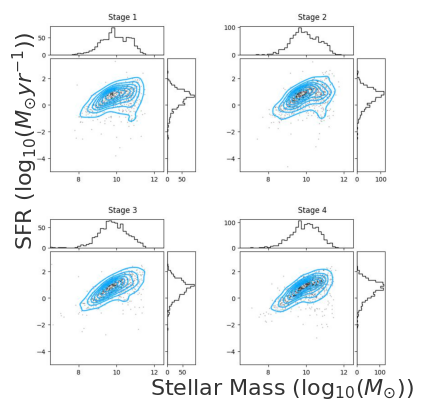

In [22]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (4,4))
counter = 0
for i in range(2):
    for j in range(2):
        im = cv.imread(im_files[counter])
        ax[i,j].imshow(im)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].axis('off')
        counter += 1
fig.text(0,0.38, 'SFR ($\log_{10}(M_{\odot}yr^{-1}$))', fontsize = 16, rotation = 90, alpha = 0.80)
fig.text(0.35,0, 'Stellar Mass ($\log_{10}(M_{\odot})$)', fontsize = 16, alpha = 0.80)
fig.tight_layout()
fig.savefig(f'{fig_folder}/sfr-mass-stages.pdf', bbox_inches = 'tight')
plt.show()

### Mass Distribution of Stages
Here, and in the next section, I want to build some normalised histograms of the masses and sfrs of the different stages.

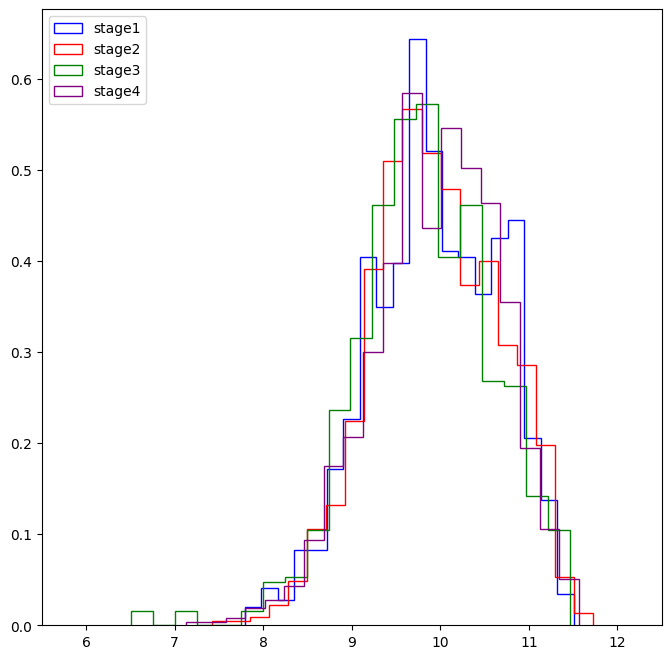

In [23]:
plt.figure(figsize = (8,8))
plt.hist(df_red.query('category == "stage1"')['lp_mass_best'], bins = 20, histtype='step', color='blue', density = True)
plt.hist(df_red.query('category == "stage2"')['lp_mass_best'], bins = 20, histtype='step', color='red', density = True)
plt.hist(df_red.query('category == "stage3"')['lp_mass_best'], bins = 20, histtype='step', color='green', density = True)
plt.hist(df_red.query('category == "stage4"')['lp_mass_best'], bins = 20,histtype='step', color='purple', density = True)
plt.legend(['stage1','stage2','stage3','stage4'], loc = 'upper left')
plt.xlim([5.5,12.5])
plt.show()

### Star Formation Between Stages

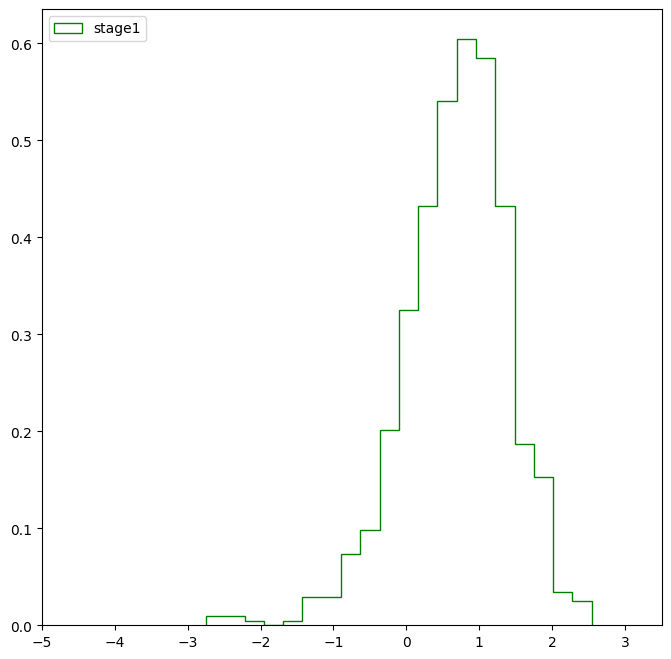

In [49]:
plt.figure(figsize = (8,8))
# plt.hist(df_red.query('category == "stage1"')['ez_sfr'], bins = 20, histtype='step', color='blue', density = True)
# plt.hist(df_red.query('category == "stage2"')['ez_sfr'], bins = 20, histtype='step', color='red', density = True)
plt.hist(df_red.query('category == "stage3"')['ez_sfr'], bins = 20, histtype='step', color='green', density = True)
# plt.hist(df_red.query('category == "stage4"')['ez_sfr'], bins = 20, histtype='step', color='purple', density = True)
plt.legend(['stage1','stage2','stage3','stage4'], loc='upper left')
plt.xlim([-5,3.5])
plt.show()

### Running KS Test

In [25]:
def weight_dist(arr1, arr2, bins=None, return_bins=True, renorm=False):
    # this will take 2 arrays of values from 2 different samples
    # e.g. redshift distributions from 2 samples
    # and return weights for each value such that the weighted
    # distributions of each sample will match.

    # note the bins need to be the same for both datasets
    # so either supply 1 number or 1 array of bin edges
    # also if you have fully specified the bins you don't need them returned
    # but if we've had to figure them out, you do need them returned
    # if you want to make sure you aren't under-weighting (e.g. if a whole dataset is
    # much larger than the other so you might always be able select >1 object
    # in dataset 1 for each object in dataset 2) then you can re-normalise to make
    # sure the max weight of both datasets is 1
    # Note, if the distributions cross this won't make a difference

    # weight arrays
    w1 = np.zeros_like(arr1)
    w2 = np.zeros_like(arr2)

    # if bins not specified, guess at them ourselves
    if bins is None:
        minsize = np.amin([    len(arr1),     len(arr2)])
        themin  = np.amin([np.amin(arr1), np.amin(arr2)])
        themax  = np.amax([np.amax(arr1), np.amax(arr2)])

        # on average 5 data points per bin, but at least 3 bins pls, max value is last bin edge
        bins = np.linspace(themin, themax, int(np.amax([(minsize/5)+1, 3])), endpoint=True)

    else:
        pass
        # because the np.histogram function can deal with distinguishing between number of bins or specific bins itself
        # so we don't have to

    hist1, thebins = np.histogram(arr1, bins=bins)  # returns (counts_arr, bins_arr)
    # use the bins from hist1 to make hist2
    # note: for these purposes, any values of hist2 outside the minmax range of hist1 should have 0 weight
    # which is taken care of by the zeros_like initialisation of w1 and w2 above
    # so it's fine for them to be excluded below
    hist2, thebins = np.histogram(arr2, bins=thebins)

    # now step through the bins and assign weights
    for i_bin in range(len(thebins)-1):
        # zero-"index"ing these because they're indices and not values
        # and if I get them mixed up below I want this to error that there's no b2 or whatever
        b0 = thebins[i_bin]
        b1 = thebins[i_bin+1]

        count1 = hist1[i_bin]
        count2 = hist2[i_bin]

        # don't miss any values and don't double-count
        if i_bin == 0:
            in_bin1 = (arr1 >= b0) & (arr1 <= b1)
            in_bin2 = (arr2 >= b0) & (arr2 <= b1)
        else: 
            in_bin1 = (arr1 >  b0) & (arr1 <= b1)
            in_bin2 = (arr2 >  b0) & (arr2 <= b1)


        # don't divide by 0 in the rest of the if/else
        if (count1 == 0) | (count2 == 0):
            w1[in_bin1] = 0.0
            w2[in_bin2] = 0.0

        elif count1 < count2:
            # weight count2 values so the sum of wt2 in this bin equals count1
            # wt_fac will always be < 1
            wt_fac = float(count1)/float(count2)
            w1[in_bin1] = 1.0
            w2[in_bin2] = wt_fac

        else:
            # weight count1 values so the sum of wt1 in this bin equals count2
            # wt_fac will always be <= 1
            wt_fac = float(count2)/float(count1)
            w1[in_bin1] = wt_fac
            w2[in_bin2] = 1.0


    # now the weights should be determined
    # we can optionally re-normalise to make sure we are getting max value out of the datasets
    if renorm:
        if (np.sum(w1) > 0.00000) & (np.amax(w1) < 1.0):
            w1 /= np.amax(w1)

        if (np.sum(w2) > 0.00000) & (np.amax(w2) < 1.0):
            w2 /= np.amax(w2)


    if return_bins:
        return w1, w2, thebins 
    else: 
        return w1, w2

In [86]:
masses_s1 = np.array(df_red.query('category == "stage1"')['lp_mass_best'])
masses_s2 = np.array(df_red.query('category == "stage2"')['lp_mass_best'])
masses_s3 = np.array(df_red.query('category == "stage3"')['lp_mass_best'])
masses_s4 = np.array(df_red.query('category == "stage4"')['lp_mass_best'])

In [107]:
weights_s1, weights_s2 = weight_dist(masses_s1, masses_s2, bins = 20, renorm = False, return_bins = False)
weights_s1_s3, weights_s3 = weight_dist(masses_s1, masses_s3, bins = 20, renorm = False, return_bins = False)
weights_s1_s4, weights_s4 = weight_dist(masses_s1, masses_s4, bins = 20, renorm = False, return_bins = False)

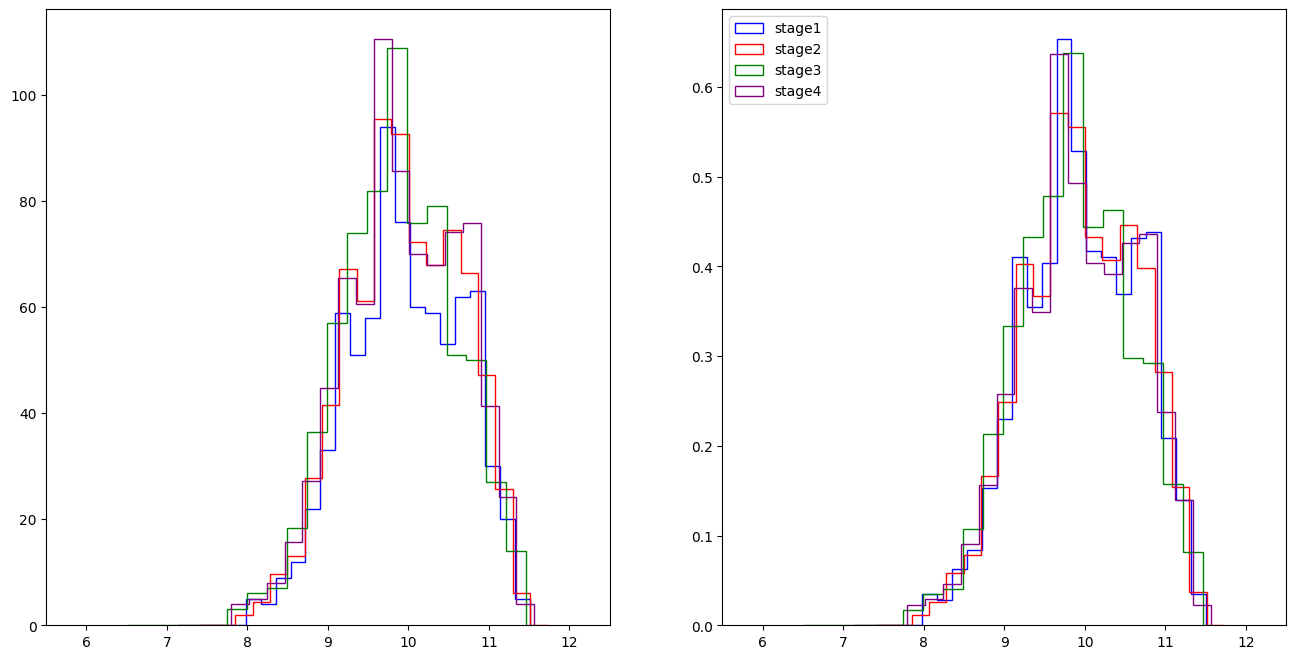

In [101]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))

ax[0].hist(masses_s1, bins = 20, histtype='step', color='blue', weights=weights_s1)
ax[0].hist(masses_s2, bins = 20, histtype='step', color='red', weights=weights_s2)
ax[0].hist(masses_s3, bins = 20, histtype='step', color='green', weights=weights_s3)
ax[0].hist(masses_s4, bins = 20, histtype='step', color='purple',weights=weights_s4)
ax[0].set_xlim([5.5, 12.5])

ax[1].hist(masses_s1, bins = 20, histtype='step', color='blue', weights=weights_s1,density=True)
ax[1].hist(masses_s2, bins = 20, histtype='step', color='red', weights=weights_s2,density=True)
ax[1].hist(masses_s3, bins = 20, histtype='step', color='green', weights=weights_s3,density=True)
ax[1].hist(masses_s4, bins = 20, histtype='step', color='purple',weights=weights_s4,density=True)

plt.legend(['stage1','stage2','stage3','stage4'], loc='upper left')
plt.xlim([5.5,12.5])
plt.show()

In [102]:
sfr_s1 = np.array(df_red.query('category == "stage1"')['ez_sfr'])
sfr_s2 = np.array(df_red.query('category == "stage2"')['ez_sfr'])
sfr_s3 = np.array(df_red.query('category == "stage3"')['ez_sfr'])
sfr_s4 = np.array(df_red.query('category == "stage4"')['ez_sfr'])

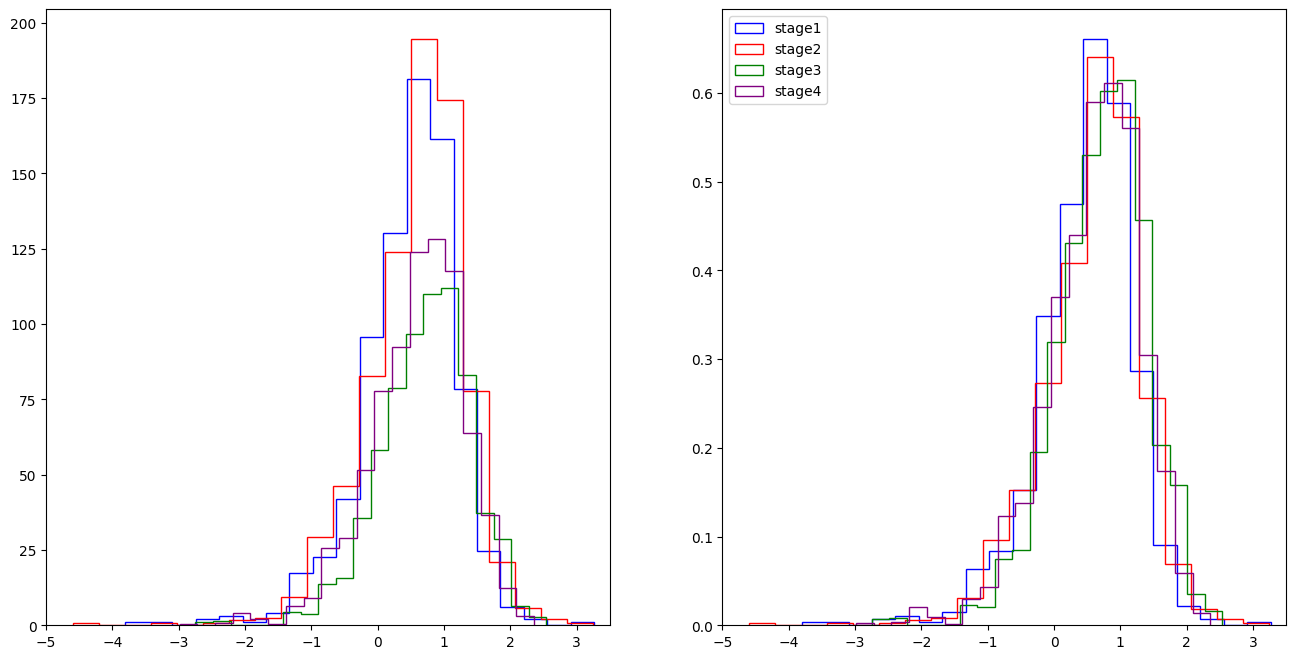

In [103]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))

ax[0].hist(sfr_s1, bins = 20, histtype='step', color='blue', weights=weights_s1)
ax[0].hist(sfr_s2, bins = 20, histtype='step', color='red', weights=weights_s2)
ax[0].hist(sfr_s3, bins = 20, histtype='step', color='green', weights=weights_s3)
ax[0].hist(sfr_s4, bins = 20, histtype='step', color='purple',weights=weights_s4)
ax[0].set_xlim([-5, 3.5])

ax[1].hist(sfr_s1, bins = 20, histtype='step', color='blue', weights=weights_s1, density=True)
ax[1].hist(sfr_s2, bins = 20, histtype='step', color='red', weights=weights_s2, density=True)
ax[1].hist(sfr_s3, bins = 20, histtype='step', color='green', weights=weights_s3, density=True)
ax[1].hist(sfr_s4, bins = 20, histtype='step', color='purple',weights=weights_s4, density=True)

plt.legend(['stage1','stage2','stage3','stage4'], loc='upper left')
plt.xlim([-5,3.5])
plt.show()

In [104]:
def ks_weighted(arr1_all, arr2_all, w1_all, w2_all, return_dist=False):

    '''
    Given 2 arrays and their weights, returns Kolmogorov-Smirnov statistic and significance.

    This differs from the usual K-S test in that it computes a weighted K-S statistic and
    assumes the size of each sample is equal to the sum of the weights, not the length of
    the array. It's not exactly standard statistical practice to do this, so use with 
    caution, but it doesn't seem like a completely ridiculous idea, either.

        Parameters:
            arr1_all   (array): a data sample with values to be weighted by w1_all
            arr2_all   (array): a data sample with values to be weighted by w2_all
            w1_all     (array): weights for arr1_all
            w2_all     (array): weights for arr2_all
            return_dist (bool): True if the array of all K-S distances should be returned,
                                default is False (mostly only useful for debugging)

            Note: the arrays should be np.array() but other data types based on that should
                  work too, e.g. pd.Series, Astropy Table columns, etc. -- but if you get
                  an error on those, wrap your inputs with np.array().

        Returns:
            ks:     the weighted, 2-sided K-S statistic
            p_ks:   the p-value based on the weighted K-S statistic
            sig_ks: the significance level (in sigma) assuming p-values are distributed Normally

            if return_dist == True, also:
                dist_arr: array of KS-distances in raw format (sorted by increasing data sample value)
                          seriously this is not useful statistically, it's just for debugging

    '''

    # drop dead weight
    arr1 = np.array(arr1_all[w1_all > 0.0])
    arr2 = np.array(arr2_all[w2_all > 0.0])
    w1   = np.array(  w1_all[w1_all > 0.0])
    w2   = np.array(  w2_all[w2_all > 0.0])

    # get effective lengths of the weighted arrays
    n1 = np.sum(w1)
    n2 = np.sum(w2)
 
    # this is used below in the k-s calculation
    # (weighted sample sizes)
    ct = np.sqrt((n1+n2)/(n1*n2))

    # we want to sort the arrays, and the weights
    i1 = arr1.argsort()
    i2 = arr2.argsort()

    # sort arrays and weights in increasing order
    arr1_s = np.array(arr1[i1])
    w1_s   = np.array(  w1[i1])
    arr2_s = np.array(arr2[i2])
    w2_s   = np.array(  w2[i2])

    # make combined arrays but track which element comes from what, then sort them again
    both   = np.concatenate([arr1_s, arr2_s])
    both_w = np.concatenate([  w1_s,   w2_s])
    track  = np.concatenate([np.zeros(len(arr1_s), dtype=int), np.ones(len(arr2_s), dtype=int)])

    i_both   = both.argsort()
    both_s   = np.array(  both[i_both])
    both_w_s = np.array(both_w[i_both])
    track_s  = np.array( track[i_both])

    # go through array, once, computing the distance as we go, and track the max distance between cumulative curves
    # (which are both stored in the same array)
    # both cumulative curves start at 0 so the distance starts at 0
    # also cumulative curves always increase
    the_dist = 0.0
    dist_arr = np.zeros_like(both_s)
    max_dist = 0.0
    for j, this_which in enumerate(track_s):
        # the key here is the distance between curves goes up if array A has a new value,
        # and then if B has a new value that curve increases too so the curves get closer together
        # (the distance goes down).
        # it doesn't matter which is curve A and which is curve B, just that one increments 
        # and the other decrements.
        # if we were doing a regular K-S without weights, each new value for a given array changes
        # the distance between curves by 1 count. 
        # (with weighted, it only changes the distance by that object's weight.)
        # And also, these are cumulative curves, so each curve is divided by the total counts in that array
        # (which in the weighted case means the sum of the weights)
        # as a check, the distances should start at 0 and end at 0 (because the cumulative fractional
        # histograms both start at 0.0 and end at 1.0)
        if this_which == 0:
            the_dist += both_w_s[j]/n1
        else:
            the_dist -= both_w_s[j]/n2

        dist_arr[j] = the_dist
        if np.abs(the_dist) > max_dist:
            max_dist = np.abs(the_dist) 

    # the max dist over the whole cumulative curves is the K-S distance
    ks = max_dist
    # p-value (which also cares about the sample sizes)
    p_ks   = special.kolmogorov(float(ks)/float(ct))
    # scipy.stats.ks_2samp uses this instead?
    p_ksalt   = kstwobign.sf(((1./ct) + 0.12 + (0.11 * ct)) * ks)
    #print(p_ksalt)

    # what's the significance assuming a normal distribution? (1 = 1 sigma, 2. = 2 sigma, 3. = 3 sigma result etc.)
    sig_ks = special.erfcinv(p_ks)*np.sqrt(2.)



    if return_dist:
        return ks, p_ks, sig_ks, dist_arr
    else: 
        return ks, p_ks, sig_ks

### Calculating Mass KS Test Weights

In [114]:
weights_s1, weights_s2 = weight_dist(masses_s1, masses_s2, bins = 20, renorm = False, return_bins = False)
weights_s1_s3, weights_s3 = weight_dist(masses_s1, masses_s3, bins = 20, renorm = False, return_bins = False)
weights_s1_s4, weights_s4 = weight_dist(masses_s1, masses_s4, bins = 20, renorm = False, return_bins = False)

In [115]:
ks_m_12, p_ks_m_12, sig_ks_12 = ks_weighted(masses_s1, masses_s2, weights_s1, weights_s2, return_dist=False)
ks_m_13, p_ks_m_13, sig_ks_13 = ks_weighted(masses_s1, masses_s3, weights_s1_s3, weights_s3, return_dist=False)
ks_m_14, p_ks_m_14, sig_ks_14 = ks_weighted(masses_s1, masses_s4, weights_s1_s4, weights_s4, return_dist=False)

In [116]:
weights_s2_s3, weights_s3 = weight_dist(masses_s2, masses_s3, bins = 20, renorm = False, return_bins = False)
weights_s2_s4, weights_s4 = weight_dist(masses_s2, masses_s4, bins = 20, renorm = False, return_bins = False)

In [117]:
ks_m_23, p_ks_m_23, sig_ks_23 = ks_weighted(masses_s2, masses_s3, weights_s2_s3, weights_s3, return_dist=False)
ks_m_24, p_ks_m_24, sig_ks_24 = ks_weighted(masses_s2, masses_s4, weights_s2_s4, weights_s4, return_dist=False)

In [118]:
weights_s3_s4, weights_s4 = weight_dist(masses_s3, masses_s4, bins = 20, renorm = False, return_bins = False)

In [119]:
ks_3_4, p_ks_m_34, sig_ks_34 = ks_weighted(masses_s3, masses_s4, weights_s3, weights_s4, return_dist=False)

In [120]:
print(f'KS-test p-value Mass between stages 1 and 2 = {p_ks_m_12}')
print(f'KS-test p-value Mass between stages 1 and 3 = {p_ks_m_13}')
print(f'KS-test p-value Mass between stages 1 and 4 = {p_ks_m_14}')
print(f'KS-test p-value Mass between stages 2 and 3 = {p_ks_m_23}')
print(f'KS-test p-value Mass between stages 2 and 4 = {p_ks_m_24}')
print(f'KS-test p-value Mass between stages 3 and 4 = {p_ks_m_34}')
print(' ')
print(f'KS-test significance Mass between stages 1 and 2 = {sig_ks_14}')
print(f'KS-test significance Mass between stages 1 and 3 = {sig_ks_24}')
print(f'KS-test significance Mass between stages 1 and 4 = {sig_ks_34}')
print(f'KS-test significance Mass between stages 2 and 3 = {sig_ks_23}')
print(f'KS-test significance Mass between stages 2 and 4 = {sig_ks_24}')
print(f'KS-test significance Mass between stages 3 and 4 = {sig_ks_34}')

KS-test p-value Mass between stages 1 and 2 = 0.9999995067044485
KS-test p-value Mass between stages 1 and 3 = 0.9962818974595212
KS-test p-value Mass between stages 1 and 4 = 0.9987438650374201
KS-test p-value Mass between stages 2 and 3 = 0.9994228527498298
KS-test p-value Mass between stages 2 and 4 = 0.9904227430002625
KS-test p-value Mass between stages 3 and 4 = 0.9874430271092601
 
KS-test significance Mass between stages 1 and 2 = 0.001574332357313783
KS-test significance Mass between stages 1 and 3 = 0.012003599847511658
KS-test significance Mass between stages 1 and 4 = 0.015738481358147084
KS-test significance Mass between stages 2 and 3 = 0.0007233468710306428
KS-test significance Mass between stages 2 and 4 = 0.012003599847511658
KS-test significance Mass between stages 3 and 4 = 0.015738481358147084


### Calculating SFR KS Test Weights

In [123]:
weights_s1, weights_s2 = weight_dist(masses_s1, masses_s2, bins = 20, renorm = False, return_bins = False)
weights_s1_s3, weights_s3 = weight_dist(masses_s1, masses_s3, bins = 20, renorm = False, return_bins = False)
weights_s1_s4, weights_s4 = weight_dist(masses_s1, masses_s4, bins = 20, renorm = False, return_bins = False)

In [124]:
ks_s_12, p_ks_s_12, sig_ks_s_12 = ks_weighted(sfr_s1, sfr_s2, weights_s1, weights_s2, return_dist=False)
ks_s_13, p_ks_s_13, sig_ks_s_13 = ks_weighted(sfr_s1, sfr_s3, weights_s1_s3, weights_s3, return_dist=False)
ks_s_14, p_ks_s_14, sig_ks_s_14 = ks_weighted(sfr_s1, sfr_s4, weights_s1_s4, weights_s4, return_dist=False)

In [125]:
weights_s2_s3, weights_s3 = weight_dist(masses_s2, masses_s3, bins = 20, renorm = False, return_bins = False)
weights_s2_s4, weights_s4 = weight_dist(masses_s2, masses_s4, bins = 20, renorm = False, return_bins = False)

In [126]:
ks_s_23, p_ks_s_23, sig_ks_s_23 = ks_weighted(sfr_s2, sfr_s3, weights_s2_s3, weights_s3, return_dist=False)
ks_s_24, p_ks_s_24, sig_ks_s_24 = ks_weighted(sfr_s2, sfr_s4, weights_s2_s4, weights_s4, return_dist=False)

In [127]:
weights_s3_s4, weights_s4 = weight_dist(masses_s3, masses_s4, bins = 20, renorm = False, return_bins = False)

In [128]:
ks_s_34, p_ks_s_34, sig_ks_s_34 = ks_weighted(sfr_s3, sfr_s4, weights_s3_s4, weights_s4, return_dist=False)

In [129]:
print(f'KS-test SFR between stages 1 and 2 = {p_ks_s_12}')
print(f'KS-test SFR between stages 1 and 3 = {p_ks_s_13}')
print(f'KS-test SFR between stages 1 and 4 = {p_ks_s_14}')
print(f'KS-test SFR between samples 2 and 3 = {p_ks_s_23}')
print(f'KS-test SFR between stages 2 and 4 = {p_ks_s_24}')
print(f'KS-test SFR between stages 3 and 4 = {p_ks_s_34}')
print(' ')
print(f'KS-test significance Mass between stages 1 and 2 = {sig_ks_s_12}')
print(f'KS-test significance Mass between stages 1 and 3 = {sig_ks_s_13}')
print(f'KS-test significance Mass between stages 1 and 4 = {sig_ks_s_14}')
print(f'KS-test significance Mass between stages 2 and 3 = {sig_ks_s_23}')
print(f'KS-test significance Mass between stages 2 and 4 = {sig_ks_s_24}')
print(f'KS-test significance Mass between stages 3 and 4 = {sig_ks_s_34}')

KS-test SFR between stages 1 and 2 = 0.010540240629260114
KS-test SFR between stages 1 and 3 = 3.943420607564361e-09
KS-test SFR between stages 1 and 4 = 0.0005580244265890282
KS-test SFR between samples 2 and 3 = 0.005388488808926789
KS-test SFR between stages 2 and 4 = 0.6059252923125253
KS-test SFR between stages 3 and 4 = 0.003642753388146898
 
KS-test significance Mass between stages 1 and 2 = 2.5575829834132247
KS-test significance Mass between stages 1 and 3 = 5.886549343626005
KS-test significance Mass between stages 1 and 4 = 3.4512364647026628
KS-test significance Mass between stages 2 and 3 = 2.7828429167927147
KS-test significance Mass between stages 2 and 4 = 0.5158985135673233
KS-test significance Mass between stages 3 and 4 = 2.9075472239490865


### Applying an Anderson-Darling Test
This just compares the results to a normal function and checks if they are from that distribution. Not 100% sure what this achieves yet.

In [89]:
ad_m1, ad_crit_m1, ad_sig_m1 = anderson(masses_s1, dist = 'norm')
ad_m2, ad_crit_m2, ad_sig_m2 = anderson(masses_s2, dist = 'norm')
ad_m3, ad_crit_m3, ad_sig_m3 = anderson(masses_s3, dist = 'norm')
ad_m4, ad_crit_m4, ad_sig_m4 = anderson(masses_s4, dist = 'norm')

In [97]:
def checking_ad_stat(stat, crit_vals):
    for i in crit_vals:
        if stat < i:
            return 'Failed'
    
    return 'Passed'

In [107]:
m1_ad_check = checking_ad_stat(ad_m1, ad_crit_m1)
m2_ad_check = checking_ad_stat(ad_m2, ad_crit_m2)
m3_ad_check = checking_ad_stat(ad_m3, ad_crit_m3)
m4_ad_check = checking_ad_stat(ad_m4, ad_crit_m4)

In [108]:
print(f'M1 distribution {m1_ad_check} the Anderson-Darling Test.')
print(f'M2 distribution {m2_ad_check} the Anderson-Darling Test.')
print(f'M3 distribution {m3_ad_check} the Anderson-Darling Test.')
print(f'M4 distribution {m4_ad_check} the Anderson-Darling Test.')

M1 distribution Passed the Anderson-Darling Test.
M2 distribution Passed the Anderson-Darling Test.
M3 distribution Failed the Anderson-Darling Test.
M4 distribution Passed the Anderson-Darling Test.


In [111]:
ad_m3

0.8164776194387287

In [101]:
ad_crit_m4

array([0.573, 0.653, 0.783, 0.913, 1.086])

In [102]:
ad_sf1, ad_crit_sf1, ad_sig_sf1 = anderson(sfr_s1, dist = 'norm')
ad_sf2, ad_crit_sf2, ad_sig_sf2 = anderson(sfr_s2, dist = 'norm')
ad_sf3, ad_crit_sf3, ad_sig_sf3 = anderson(sfr_s3, dist = 'norm')
ad_sf4, ad_crit_sf4, ad_sig_sf4 = anderson(sfr_s4, dist = 'norm')

In [103]:
m1_ad_check = checking_ad_stat(ad_sf1, ad_crit_sf1)
m2_ad_check = checking_ad_stat(ad_sf2, ad_crit_sf2)
m3_ad_check = checking_ad_stat(ad_sf3, ad_crit_sf3)
m4_ad_check = checking_ad_stat(ad_sf4, ad_crit_sf4)

In [105]:
print(f'SF1 distribution {m1_ad_check} the Anderson-Darling Test.')
print(f'SF2 distribution {m2_ad_check} the Anderson-Darling Test.')
print(f'SF3 distribution {m3_ad_check} the Anderson-Darling Test.')
print(f'SF4 distribution {m4_ad_check} the Anderson-Darling Test.')

SF1 distribution Passed the Anderson-Darling Test.
SF2 distribution Passed the Anderson-Darling Test.
SF3 distribution Passed the Anderson-Darling Test.
SF4 distribution Passed the Anderson-Darling Test.
